# Import Libraries and Explore Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline

housing = pd.read_csv('AmesHousing.tsv', delimiter='\t')
housing.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

# Create Functions

In [42]:
def transform_features(df, k=0):
    
    saleprice = df['SalePrice']
    
    convert_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Mo Sold']
    df[convert_cols] = df[convert_cols].astype('object')
    text_cols = df.select_dtypes(include='object').columns
    text_cols = text_cols.drop(['Sale Condition', 'Sale Type'])
    dummy_cols = pd.DataFrame()
    for col in text_cols:
        dummy_cols = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummy_cols], axis=1)
        df = df.drop(col, axis=1)
    
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    #df['years_until_garage'] = df['Garage Yr Blt'] - df['Year Built']
    #df['garage_age_years'] = df['Yr Sold'] - df['Garage Yr Blt']
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['house_age_years'] = df['Yr Sold'] - df['Year Built']
    
    drop_columns = ['Order', 'PID', 'Year Built', 'Year Remod/Add', 'Yr Sold', 'Misc Val']
    df = df.drop(drop_columns, axis=1)
    df['SalePrice'] = saleprice
    
    df = df.dropna(thresh=len(df)*0.95, axis=1).copy()
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    halfway = int(len(df)/2)
    if k==0:
        train = df[:halfway]
        test = df[halfway:]
        return train, test
    elif k==1:
        df = df.iloc[np.random.permutation(len(df))]
        fold_one = df[:halfway]
        fold_two = df[halfway:]
        train1 = fold_one
        test1 = fold_two
        train2 = fold_two
        test2 = fold_two
        return train1, test1, train2, test2
    elif k>1:
        return df
    else:
        return "Error: k must be positive"


In [3]:
def select_features(df, features = ['Gr Liv Area', 'SalePrice'], k=0):
    if k==0:
        train, test = transform_features(df, k)
        train = train[features]
        test = test[features]
        return train, test
    elif k==1:
        train1, test1, train2, test2 = transform_features(df, k)
        train1 = train1[features]
        test1 = test1[features]
        train2 = train2[features]
        test2 = test2[features]
        return train1, test1, train2, test2
    elif k>1:
        df = transform_features(df, k)
        df = df[features]
        return df
    else:
        return "Error: k must be positive"

In [46]:
def train_and_test(df, model, features=['Gr Liv Area', 'SalePrice'], k=0):
    target_col = 'SalePrice'
    
    if k==0:
        train, test = select_features(df, features, k)
        feature_cols = train.columns.drop(target_col)
        
        train_X = train[feature_cols].select_dtypes(include='number')
        train_y = train[target_col]
        test_X = test[feature_cols].select_dtypes(include='number')
        test_y = test[target_col]
        model.fit(train_X, train_y)
        predictions = model.predict(test_X)
        rmse = mean_squared_error(test_y, predictions)**(1/2)
        return rmse
    
    elif k==1:
        train1, test1, train2, test2 = select_features(df, features, k)
        feature_cols = train1.columns.drop(target_col)
        
        model1 = model
        train1_X = train1[feature_cols].select_dtypes(include='number')
        train1_y = train1[target_col]
        test1_X = test1[feature_cols].select_dtypes(include='number')
        test1_y = test1[target_col]
        model1.fit(train1_X, train1_y)
        predictions1 = model1.predict(test1_X)
        rmse1 = mean_squared_error(test1_y, predictions1)**(1/2)
        
        model2 = model
        train2_X = train2[feature_cols].select_dtypes(include='number')
        train2_y = train2[target_col]
        test2_X = test2[feature_cols].select_dtypes(include='number')
        test2_y = test2[target_col]
        model2.fit(train2_X, train2_y)
        predictions2 = model2.predict(test2_X)
        rmse2 = mean_squared_error(test2_y, predictions2)**(1/2)
        
        avg_rmse = (rmse1 + rmse2)/2
        return avg_rmse
    
    elif k > 1:
        df = select_features(df, features, k)
        feature_cols = df.columns.drop(target_col)
        
        kf = KFold(k, shuffle=True)
        mses = cross_val_score(model, df[feature_cols], df[target_col],
                              scoring='neg_mean_squared_error', cv=kf)
        avg_rmse = (abs(mses)**(1/2)).mean()
        return avg_rmse   

# Generate Heatmaps for Feature Selection

In [5]:
#separate functions for num and obj features for heatmap
def transform_num_features(df):
    
    df = df.dropna(thresh=len(df)*0.95, axis=1).copy()
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mode())
    
    convert_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Mo Sold']
    df[convert_cols] = df[convert_cols].astype('object')
    df = df.select_dtypes(include='number')
    
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    #df['years_until_garage'] = df['Garage Yr Blt'] - df['Year Built']
    #df['garage_age_years'] = df['Yr Sold'] - df['Garage Yr Blt']
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['house_age_years'] = df['Yr Sold'] - df['Year Built']
    
    drop_columns = ['Order', 'PID', 'Year Built', 'Year Remod/Add', 'Yr Sold', 'Misc Val']
    df = df.drop(drop_columns, axis=1)
    
    halfway = int(len(df)/2)
    train = df[:halfway]
    test = df[halfway:]
    
    return train, test

def transform_obj_features(df):
    
    df = df.dropna(thresh=len(df)*0.95, axis=1).copy()
    
    convert_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Mo Sold']
    df[convert_cols] = df[convert_cols].astype('object')
    text_cols = df.select_dtypes(include='object').columns
    text_cols = text_cols.drop(['Sale Condition', 'Sale Type'])
    saleprice = df['SalePrice']
    df = df[text_cols]
    df['SalePrice'] = saleprice
    dummy_cols = pd.DataFrame()
    for col in text_cols:
        dummy_cols = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummy_cols], axis=1)
        df = df.drop(col, axis=1)
    
    halfway = int(len(df)/2)
    train = df[:halfway]
    test = df[halfway:]
    
    return train, test

## Correlations for Numeric Features

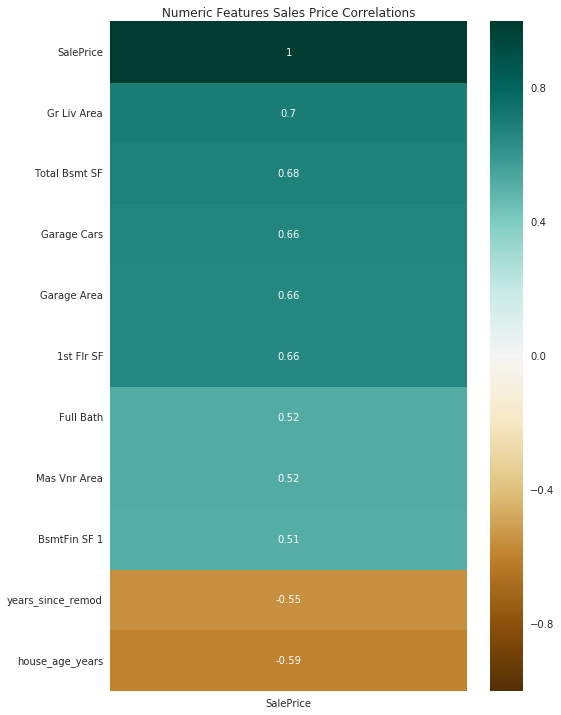

In [6]:
train_num, test = transform_num_features(housing)

#heatmap of just correlations with SalePrice
plt.figure(figsize=(8, 12))
sale_price_corr = train_num.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
sale_price_corr = sale_price_corr[abs(sale_price_corr['SalePrice']) > 0.5]

sns.heatmap(sale_price_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Numeric Features Sales Price Correlations')
plt.show()

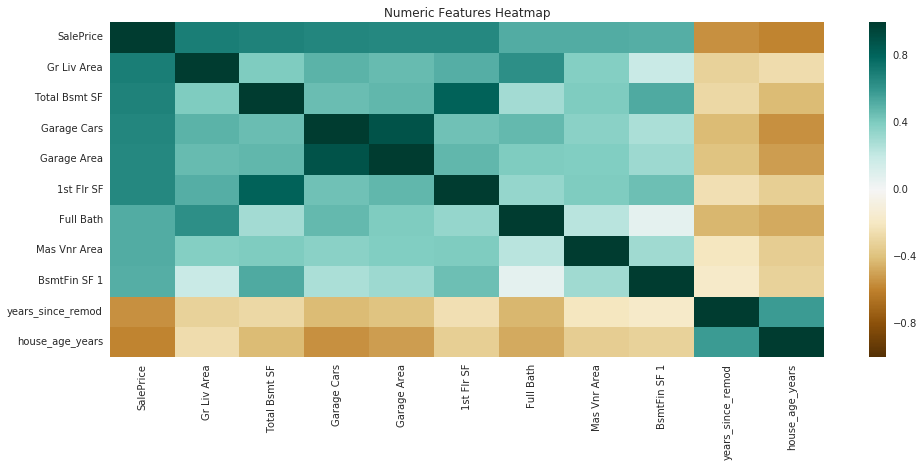

In [7]:
#full heatmap
train_num_corr = train_num.corr()[sale_price_corr.index]
train_num_corr = train_num_corr.loc[sale_price_corr.index]
plt.figure(figsize=(16,6))
#mask = np.triu(np.ones_like(train_num.corr(), dtype=np.bool))
sns.heatmap(train_num_corr, vmin=-1, vmax=1, cmap='BrBG')
plt.title('Numeric Features Heatmap')
plt.show()

## Correlations for Object Features

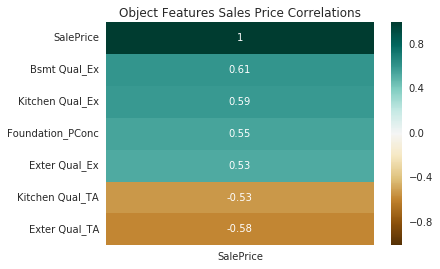

In [8]:
train_obj, test = transform_obj_features(housing)

sale_price_corr = train_obj.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
sale_price_corr = sale_price_corr[abs(sale_price_corr['SalePrice']) > 0.5]
sns.heatmap(sale_price_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title("Object Features Sales Price Correlations")
plt.show()

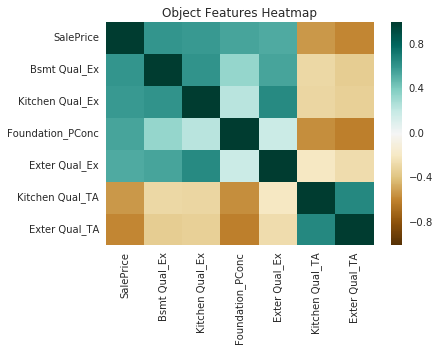

In [9]:
train_obj_corr = train_obj.corr()[sale_price_corr.index]
train_obj_corr = train_obj_corr.loc[sale_price_corr.index]
sns.heatmap(train_obj_corr, vmin=-1, vmax=1, cmap='BrBG')
plt.title('Object Features Heatmap')
plt.show()

# Validating Models

In [51]:
train_and_test(housing, LinearRegression())

57120.50729008638

In [52]:
train_and_test(housing, LinearRegression(), k=1)

54829.2329506963

In [50]:
train_and_test(housing, LinearRegression(), k=10)

56384.43314418597

In [55]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'house_age_years',
                        'SalePrice'])


42473.5410262782

In [56]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'house_age_years',
                        'SalePrice'], k=1)


41394.26806168821

In [57]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'house_age_years',
                        'SalePrice'], k=10)


37703.39489629689

In [39]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'Exter Qual_TA', 'house_age_years',
                        'SalePrice'])


41731.70827042949

In [53]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'Exter Qual_TA', 'house_age_years',
                        'SalePrice'], k=1)


37959.12782152285

In [54]:
train_and_test(housing, LinearRegression(), 
               features=['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars',
                        'Bsmt Qual_Ex', 'Exter Qual_TA', 'house_age_years',
                        'SalePrice'], k=10)


36753.17684421032